In [ ]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport util

In [3]:
import numpy as np
import cupy as cp
import cuml
from sklearn.model_selection import KFold

from util import get_data, plot_activations

In [4]:
train_cross_X, train_cross_y, test_cross_X, test_cross_y = get_data("cross", "val")
train_cross_X.shape, train_cross_y.shape

((64, 248, 35624), (64,))

In [5]:
assert train_cross_X.shape == (64, 248, 35624)
assert train_cross_y.shape == (64,)

In [6]:
test_cross_X.shape, test_cross_y.shape

((32, 248, 35624), (32,))

In [7]:
assert test_cross_X.shape == (32, 248, 35624)
assert test_cross_y.shape == (32,)

In [8]:
class_names = set(train_cross_y)
class_names

{'rest', 'task_motor', 'task_story_math', 'task_working_memory'}

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_cross_y = label_encoder.fit_transform(train_cross_y)
test_cross_y = label_encoder.transform(test_cross_y)

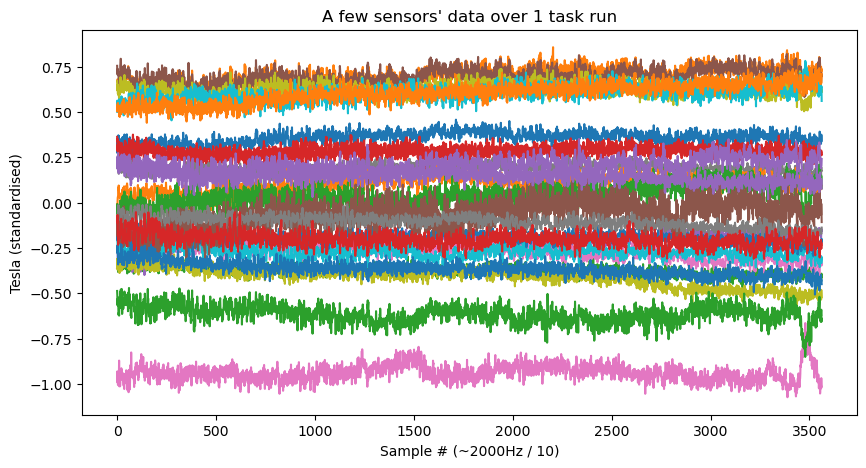

In [59]:
from matplotlib import pyplot as plt

# Downsample rate (just for graph)
downsample = 10

# Create a figure and axis
_, ax = plt.subplots(figsize=(10, 5))

# Plotting each dimension (sensor) separately
for i in range(0, train_cross_X.shape[1], 10):  # Looping over the first two dimensions
    ax.plot(train_cross_X[0, i, ::downsample], label=f"Sensor {i+1}")

# Setting labels and title
ax.set_xlabel(f"Sample # (~2000Hz / {downsample})")
ax.set_ylabel("Tesla (standardised)")
ax.set_title("A few sensors' data over 1 task run")

# Display the plot
plt.show()

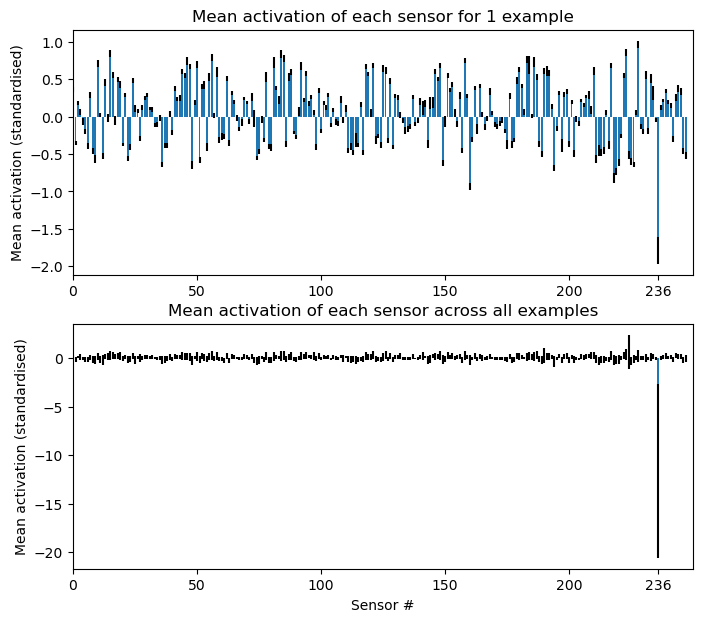

Sensors with absolute mean >1.5: (array([236]),)


In [10]:
plot_activations(train_cross_X)

In [11]:
train_cross_X = np.delete(train_cross_X, 236, axis=1)
test_cross_X = np.delete(test_cross_X, 236, axis=1)

In [12]:
from sklearn.decomposition import PCA

def perform_pca(data: np.ndarray, n_components = None):
    reshaped = data.reshape(-1, data.shape[-1])
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(reshaped)

    return pca, principal_components

In [13]:
pca_results, pca_components = perform_pca(train_cross_X, n_components=10)

In [14]:
print(f"Explained variance: {np.sum(pca_results.explained_variance_ratio_):.5%}\n"
      f"Number of components: {pca_results.n_components_}")

Explained variance: 99.16737%
Number of components: 10


In [15]:
# (Below are copied from intra, and aren't as accurate for cross, but you get the picture)
# 10   features, 99.580% variance explained
# 100  features, 99.825% variance explained
# 250  features, 99.905% variance explained
# 1000 features, 99.968% variance explained

In [16]:
def get_pca(data: np.ndarray, n_components=10):
    return PCA(n_components=n_components).fit(data)

In [17]:
def logistic_regression_pcad_train(X_train, y_train, n_components=10):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=n_components)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0], -1)

    model = LogisticRegressionSklearn(random_state=0)
    model.fit(reshaped_X_train, y_train)

    return pca, model

SyntaxError: invalid syntax (1692136222.py, line 13)

In [ ]:
def logistic_regression_pcad_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0], -1)

    return model.score(reshaped_X_val, y_test)

In [20]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn

def logistic_regression_pcad_run(X: np.ndarray, y: np.ndarray, n_splits=5, n_components=10):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        pca, model = logistic_regression_pcad_train(X_train, y_train, n_components)
        
        score = logistic_regression_pcad_test(X_val, y_val, pca, model)
        scores.append(score)

    return sum(scores) / len(scores), scores

In [ ]:
pca, model = logistic_regression_pcad_train(train_cross_X[:, :, :], train_cross_y, n_components=10)

score = logistic_regression_pcad_test(test_cross_X[:, :, :], test_cross_y, pca, model)

In [ ]:
print(f"Accuracy for Logistic Regression with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

In [ ]:
from cuml.linear_model import LogisticRegression

def logistic_regression(X: np.ndarray, y: np.ndarray, n_splits=5):
    X = cp.asarray(X.reshape(X.shape[0], -1).astype(np.float32))
    y = cp.asarray(y)
    
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    scores = []
    for train_idxs, val_idxs in kfold.split(X):
        X_train, X_val = X[train_idxs], X[val_idxs]
        y_train, y_val = y[train_idxs], y[val_idxs]

        model = LogisticRegression()
        
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_val, y_val))
    
    return sum(scores) / len(scores), scores

In [ ]:
result, scores = logistic_regression(train_cross_X[:, :, ::2], train_cross_y)

In [ ]:
print(f"Accuracy: {result:.1%}")

In [ ]:
def logistic_regression_train(X: np.ndarray, y: np.ndarray):
    X = cp.asarray(X.reshape(X.shape[0], -1).astype(np.float32))
    y = cp.asarray(y)
    
    model = LogisticRegression()
    
    model.fit(X, y)
    
    return model

In [55]:
def logistic_regression_test(X: np.ndarray, y: np.ndarray, model):
    X = cp.asarray(X.reshape(X.shape[0], -1).astype(np.float32))
    y = cp.asarray(y)
    
    y_pred = model.predict(X)
    
    cm = cuml.metrics.confusion_matrix(y, y_pred)
    accuracy = cp.mean(y == y_pred)
    
    return accuracy, cm

In [56]:
model = logistic_regression_train(train_cross_X[:, :, :], train_cross_y)

[W] [01:03:27.648521] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


In [57]:
score, cm = logistic_regression_test(test_cross_X[:, :, :], test_cross_y, model)

In [58]:
print(f"Accuracy for Logistic Regression on all features:\n"
      f"Accuracy: {score:.1%}")

Accuracy for Logistic Regression on all features:
Accuracy: 50.0%


In [20]:
import pandas as pd

class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
pd.DataFrame(cp.asnumpy(cm), index=class_names, columns=class_names)

,rest,task_motor,task_story_math,task_working_memory
rest,5,0,0,3
task_motor,0,4,4,0
task_story_math,0,4,4,0
task_working_memory,1,0,4,3


In [33]:
# import cupy
# 
# import gc
# 
# gc.collect()
# # run weird cuml command to free memory
# cupy.get_default_memory_pool().free_all_blocks()

In [28]:
from cuml.svm import SVC

def svm_train(X: np.ndarray, y: np.ndarray):
    X = cp.asarray(X.reshape(X.shape[0], -1).astype(np.float32))
    y = cp.asarray(y)
    
    print(X.shape)
    model = SVC(C=1.0, kernel="rbf", gamma="scale")
    
    model.fit(X, y)
    
    return model

In [35]:
def svm_test(X: np.ndarray, y: np.ndarray, model):
    X = cp.asarray(X.reshape(X.shape[0], -1).astype(np.float32))
    y = cp.asarray(y)
    
    y_pred = model.predict(X)
    
    cm = cuml.metrics.confusion_matrix(y, y_pred)
    accuracy = cp.mean(y == y_pred)
    
    return accuracy, cm

In [36]:
model = svm_train(train_cross_X[:, :, ::2], train_cross_y)

(64, 4399564)


In [37]:
score, cm = svm_test(test_cross_X[:, :, ::2], test_cross_y, model)

In [38]:
print(f"Accuracy: {score:.1%}")

Accuracy: 56.2%


In [29]:
def svm_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    X_train = cp.asarray(X_train.reshape(X_train.shape[0], -1).astype(np.float32))
    y_train = cp.asarray(y_train)
    
    X_val = cp.asarray(X_val.reshape(X_val.shape[0], -1).astype(np.float32))
    y_val = cp.asarray(y_val)

    param_grid = {
        'C': [1, 10, 100, 1000],
        'kernel': ['rbf', 'sigmoid'],
    }

    grid_scores = {}
    for C in param_grid['C']:
        for kernel in param_grid['kernel']:
            model = SVC(C=C, kernel=kernel)
            model.fit(X_train, y_train)

            score = model.score(X_val, y_val)
            grid_scores[(C, kernel, None)] = score
            print(f"C: {C}, kernel: {kernel}, score: {score:.1%}")

    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

In [31]:
grid_scores = svm_grid_search(train_cross_X[:, :, ::2], train_cross_y, test_cross_X[:, :, ::2], test_cross_y)

C: 1, kernel: rbf, score: 56.2%
C: 1, kernel: sigmoid, score: 56.2%
C: 10, kernel: rbf, score: 65.6%
C: 10, kernel: sigmoid, score: 46.9%
C: 100, kernel: rbf, score: 65.6%
C: 100, kernel: sigmoid, score: 43.8%
C: 1000, kernel: rbf, score: 65.6%
C: 1000, kernel: sigmoid, score: 43.8%

Best Parameters: (10, 'rbf', None)
Best Score: 65.6%


In [42]:
sorted(grid_scores.items(), key=lambda kv: kv[1], reverse=True)

[((10, 'rbf', None), 0.65625),
 ((100, 'rbf', None), 0.65625),
 ((1000, 'rbf', None), 0.65625),
 ((1, 'rbf', None), 0.5625),
 ((1, 'sigmoid', None), 0.5625),
 ((10, 'sigmoid', None), 0.46875),
 ((100, 'sigmoid', None), 0.4375),
 ((1000, 'sigmoid', None), 0.4375)]

In [24]:
def lr_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=100)  # Even just 10 works
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0], -1)
    
    param_grid = {
        'C': [1, 10, 100, 250, 500, 1000, 10000],
        'penalty': ['l2'],
    }

    grid_scores = {}
    for C in param_grid['C']:
        for penalty in param_grid['penalty']:
            solver = 'lbfgs'
            if penalty == 'l1':
                solver = 'saga'
            model = LogisticRegressionSklearn(random_state=0, C=C, penalty=penalty, solver=solver, max_iter=1000)
            model.fit(reshaped_X_train, y_train)

            score = model.score(X_val, y_val)
            grid_scores[(C, penalty)] = score
            print(f"C: {C}, penalty: {penalty}. Score: {score:.1%}")

    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

In [25]:
grid_scores_lr = lr_grid_search(train_cross_X[:, :, :], train_cross_y, test_cross_X[:, :, :], test_cross_y)

C: 1, penalty: l2. Score: 62.5%
C: 10, penalty: l2. Score: 59.4%
C: 100, penalty: l2. Score: 65.6%
C: 250, penalty: l2. Score: 62.5%
C: 500, penalty: l2. Score: 62.5%
C: 1000, penalty: l2. Score: 62.5%
C: 10000, penalty: l2. Score: 62.5%

Best Parameters: (100, 'l2')
Best Score: 65.6%


In [27]:
from sklearn.neighbors import KNeighborsClassifier

def knn_train(X: np.ndarray, y: np.ndarray, n_neighbors=5):
    reshaped_X_train = X.reshape(-1, X.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=10)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X.shape[0], -1)
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    model.fit(reshaped_X_train, y)
    
    return pca, model

In [28]:
def knn_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0], -1)

    return model.score(reshaped_X_val, y_test)

In [32]:
pca, model = knn_train(train_cross_X[:, :, :], train_cross_y, n_neighbors=4)

In [33]:
score = knn_test(test_cross_X[:, :, :], test_cross_y, pca, model)

In [35]:
for n_neighbors in range(1, 10, 2):
    pca, model = knn_train(train_cross_X[:, :, :], train_cross_y, n_neighbors=n_neighbors)
    score = knn_test(test_cross_X[:, :, :], test_cross_y, pca, model)
    print(f"n_neighbors: {n_neighbors}, score: {score:.1%}")

n_neighbors: 1, score: 53.1%
n_neighbors: 3, score: 43.8%
n_neighbors: 5, score: 43.8%
n_neighbors: 7, score: 50.0%
n_neighbors: 9, score: 43.8%


In [34]:
print(f"Accuracy for KNN with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

Accuracy for KNN with 10 (or 100, it's the same) principal components:
37.5%


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

def hgb_train(X: np.ndarray, y: np.ndarray):
    reshaped_X_train = X.reshape(-1, X.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=100)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X.shape[0], -1)
    
    model = HistGradientBoostingClassifier(random_state=0)
    
    model.fit(reshaped_X_train, y)
    
    return pca, model

In [18]:
def hgb_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0], -1)

    return model.score(reshaped_X_val, y_test)

In [23]:
pca, model = hgb_train(train_cross_X[:, :, :], train_cross_y)

In [24]:
score = hgb_test(test_cross_X[:, :, :], test_cross_y, pca, model)

In [25]:
print(f"Accuracy for HGB with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

Accuracy for HGB with 10 (or 100, it's the same) principal components:
37.5%


In [28]:
def hgb_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=100)  # Even just 10 works
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0], -1)
    
    param_grid = {
        'learning_rate': [0.2, 0.05, 0.01],
        'max_iter': [100, 300],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [10, 50, 100],
        'l2_regularization': [0.0, 0.1, 0.5],
    }

    grid_scores = {}
    for learning_rate in param_grid['learning_rate']:
        for max_iter in param_grid['max_iter']:
            for max_depth in param_grid['max_depth']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for l2_regularization in param_grid['l2_regularization']:
                        model = HistGradientBoostingClassifier(random_state=0, learning_rate=learning_rate, max_iter=max_iter, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)
                        model.fit(reshaped_X_train, y_train)

                        score = model.score(X_val, y_val)
                        grid_scores[(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization)] = score
                        print(f"learning_rate: {learning_rate}, max_iter: {max_iter}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, l2_regularization: {l2_regularization}. Score: {score:.1%}")
    
    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

In [29]:
grid_scores_hgb = hgb_grid_search(train_cross_X[:, :, :], train_cross_y, test_cross_X[:, :, :], test_cross_y)

learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.0. Score: 65.6%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.1. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.5. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 50, l2_regularization: 0.0. Score: 25.0%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 50, l2_regularization: 0.1. Score: 25.0%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 50, l2_regularization: 0.5. Score: 25.0%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 100, l2_regularization: 0.0. Score: 25.0%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 100, l2_regularization: 0.1. Score: 25.0%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 100, l2_regularization: 0.5. Score: 25.0

In [30]:
sorted(grid_scores_hgb.items(), key=lambda kv: kv[1], reverse=True)

[((0.2, 100, None, 10, 0.0), 0.65625),
 ((0.2, 100, 5, 10, 0.0), 0.65625),
 ((0.2, 100, 10, 10, 0.0), 0.65625),
 ((0.2, 300, None, 10, 0.0), 0.65625),
 ((0.2, 300, 5, 10, 0.0), 0.65625),
 ((0.2, 300, 10, 10, 0.0), 0.65625),
 ((0.05, 300, None, 10, 0.0), 0.65625),
 ((0.05, 300, 5, 10, 0.0), 0.65625),
 ((0.05, 300, 10, 10, 0.0), 0.65625),
 ((0.2, 100, None, 10, 0.1), 0.59375),
 ((0.2, 100, None, 10, 0.5), 0.59375),
 ((0.2, 100, 5, 10, 0.1), 0.59375),
 ((0.2, 100, 5, 10, 0.5), 0.59375),
 ((0.2, 100, 10, 10, 0.1), 0.59375),
 ((0.2, 100, 10, 10, 0.5), 0.59375),
 ((0.2, 300, None, 10, 0.1), 0.59375),
 ((0.2, 300, None, 10, 0.5), 0.59375),
 ((0.2, 300, 5, 10, 0.1), 0.59375),
 ((0.2, 300, 5, 10, 0.5), 0.59375),
 ((0.2, 300, 10, 10, 0.1), 0.59375),
 ((0.2, 300, 10, 10, 0.5), 0.59375),
 ((0.05, 100, None, 10, 0.0), 0.59375),
 ((0.05, 100, None, 10, 0.1), 0.59375),
 ((0.05, 100, None, 10, 0.5), 0.59375),
 ((0.05, 100, 5, 10, 0.0), 0.59375),
 ((0.05, 100, 5, 10, 0.1), 0.59375),
 ((0.05, 100, 5, 10